In [1]:
# 获取数据
%reload_ext autoreload
%autoreload 2
import sys
# 替换为fun.py实际所在的绝对路径（比如："D:/projects/common_code"） D:\桌面\策略\fun.py
sys.path.append("D://桌面/策略")
from fun import *
import polars as pl
import pandas as pd
import datetime as dt
import time 


start_date = dt.date(2024,1,1)
end_date = dt.date(2025,1,1)

# 获取指定日期的日线数据
stock_data = read_day_data(start_date=start_date,end_date=end_date,file_path='ts_stock_all_data')
stock_data = stock_data.drop_nulls(subset=['open','close','pre_close','limit_up','limit_down'])
close = stock_data.to_pandas().pivot(index='trading_date',columns='code',values='close')


In [2]:
from alpha import *
# 1.计算因子值（polars用长数据格式即可），下期收益
# 定义因子计算逻辑(20天成交量平均/50天成交量平均)
stock_data = stock_data.sort(['code','trading_date'])
stock_data = stock_data.with_columns([
    (pl.col('volume').rolling_mean(window_size=10)).over('code').alias('volume_ma10'),
    (pl.col('volume').rolling_mean(window_size=60)).over('code').alias('volume_ma60'),
    ((pl.col('close').shift(-5) - pl.col('close')) / pl.col('close')*100).over('code').alias('future_return_5d')
])
stock_data = stock_data.with_columns([
    (pl.col('volume_ma10') / pl.col('volume_ma60')).alias('volume_factor'),
])

# 2.因子的预处理
# 去掉缺失值
stock_data = stock_data.drop_nulls(subset=['volume_factor'])
stock_data.select(['code','trading_date','name','volume','volume_ma10','volume_ma60','volume_factor','float_mv'])

# 市值中性化
stock_data = stock_data.group_by('trading_date').map_groups(
    lambda df: ols_neutralize(df, y_column='volume_factor', x_columns=['float_mv'])
)

factor_data = stock_data.to_pandas().pivot(index='trading_date',columns='code',values='volume_factor_neutralized')


2025-12-07 02:06:27,247 - DEBUG - matplotlib data path: d:\Anaconda_envs\envs\quant\lib\site-packages\matplotlib\mpl-data
2025-12-07 02:06:27,261 - DEBUG - CONFIGDIR=C:\Users\20561\.matplotlib
2025-12-07 02:06:27,295 - DEBUG - interactive is False
2025-12-07 02:06:27,296 - DEBUG - platform is win32
2025-12-07 02:06:27,374 - DEBUG - CACHEDIR=C:\Users\20561\.matplotlib
2025-12-07 02:06:27,382 - DEBUG - Using fontManager instance from C:\Users\20561\.matplotlib\fontlist-v390.json


开始因子分析: 2024-01-01 ~ 2025-01-01 | 持仓5天 | 调仓1天
有效交易日: 178 | 调仓日: 178

==== 一、IC/IR分析（纯宽表计算） ====
IC均值: -0.0601 | IC_IR: -0.7082 | IC>0占比: 23.60%
RankIC均值: -0.0758 | RankIC_IR: -0.7489 | RankIC>0占比: 22.47%

==== 二、分组收益分析 ====
分组收益统计:
  group  mean_daily_ret  annual_ret   sharpe  max_dd  pos_ratio
0    G1          0.0081      0.4096  52.3874 -0.6030     0.4831
1    G2          0.0066      0.3349  45.6566 -0.5997     0.4607
2    G3          0.0057      0.2886  40.4367 -0.6134     0.4663
3    G4          0.0044      0.2229  30.8382 -0.6652     0.4382
4    G5         -0.0012     -0.0592  -7.7694 -0.7985     0.4326


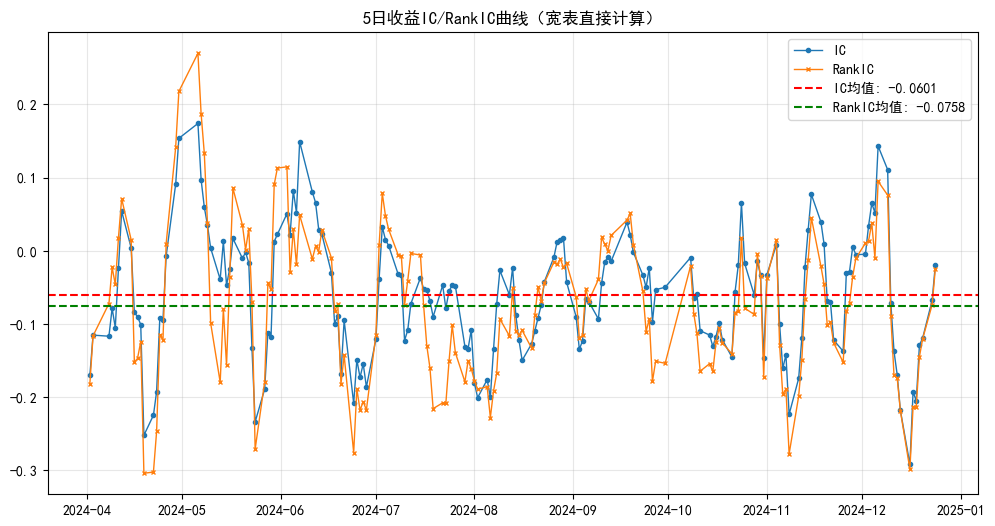

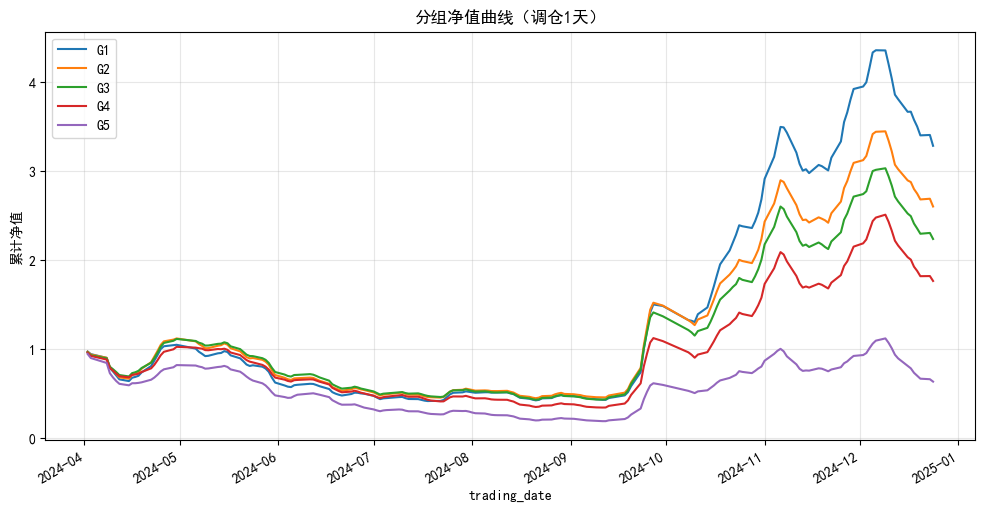

{'ic_df':                       ic     rank_ic
 trading_date                        
 2024-04-02   -0.17015122 -0.18159656
 2024-04-03   -0.11522879 -0.11618803
 2024-04-08   -0.11668392 -0.07209572
 2024-04-09   -0.07857017 -0.02262796
 2024-04-10   -0.10498731 -0.04594912
 ...                  ...         ...
 2024-12-18   -0.20518430 -0.21276578
 2024-12-19   -0.12879395 -0.14466455
 2024-12-20   -0.11945392 -0.12047036
 2024-12-23   -0.06762298 -0.07363662
 2024-12-24   -0.01942590 -0.02474996
 
 [178 rows x 2 columns],
 'ic_stats': {'ic_mean': np.float64(-0.06005643568002468),
  'ic_ir': np.float64(-0.7081770121347362),
  'rank_ic_mean': np.float64(-0.07575266276775196),
  'rank_ic_ir': np.float64(-0.7489102935017233),
  'ic_pos_ratio': np.float64(0.23595505617977527),
  'rank_ic_pos_ratio': np.float64(0.2247191011235955)},
 'group_returns':                       G1          G2          G3          G4          G5
 trading_date                                                       

In [ ]:
a=analyze_factor(
    factor_data=factor_data,
    close_data=close,
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d'),
    adjust_freq=1,
    return_period=5,
    group_num=5,
    save_result=False
)